# Prosper loans dataset Investigation
## by Marwa Qabeel

## Investigation Overview

In this investigation I wanted to figure out two things:
<ul>
    <li>The factors which can be used to predict default on credit.</li>
    <li>What factors influence Prosper rating.</li>
</ul>

## Dataset Overview

This data set contains 113,937 loans with 81 variables on each loan, for the purpose of this investigation I've taken the following variables: <b>Term, LoanStatus, BorrowerRate, ProsperRating (Alpha), ListingCategory (numeric), EmploymentStatus, DelinquenciesLast7Years, StatedMonthlyIncome, TotalProsperLoans, LoanOriginalAmount, LoanOriginationDate, Recommendations, Investors</b>. After adjusting and wrangling dataset contained 26005 data points.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('prosperLoanData.csv')

In [3]:
# setting default color
default_color = sb.color_palette('muted')[4]
# getting rid of scientific notation
pd.options.display.float_format = '{:.2f}'.format

## Wrangling
There were three major issues with data:
<ol>
    <li>Prosper started to use Prosper rating from 2009. Pre 2009 Prosper used Credit Grade. I had to remove pre 2009 data points entirely</li>
    <li>Most of the loans in dataset are actually current loans and can not be used to determine how default on credit can be predicted. Defaulted credits were split in two categries chargedoff and defaulted (see sub-slide). To solve this I've removed all the current loans and merged chargedoff and defaulted credits together.</li>
    <li>Stated monthly income had an unusually high number of outliers and very large range of values from 0 to 1 750 000. To solve this I've dropped all the data above three standard deviations from the mean.</li>
</ol>

In [4]:
# droping pre-2009 data
target_df = df.dropna(subset=['ProsperRating (Alpha)']).reset_index()

In [5]:
target_df['StatedMonthlyIncome'].describe()

count     84853.00
mean       5931.17
std        8239.94
min           0.00
25%        3434.00
50%        5000.00
75%        7083.33
max     1750002.92
Name: StatedMonthlyIncome, dtype: float64

In [6]:
income_std = target_df['StatedMonthlyIncome'].std()
income_mean = target_df['StatedMonthlyIncome'].mean()
boundary = income_mean + income_std * 3
boundary

30651.006023351034

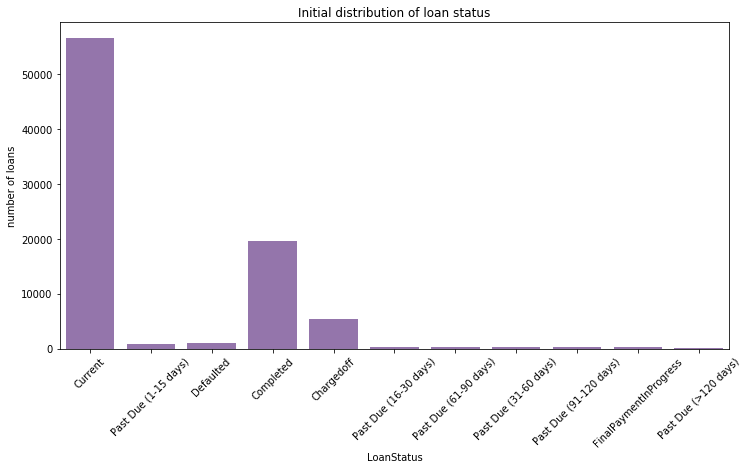

In [7]:
plt.figure(figsize=[12, 6])
plt.xticks(rotation=45)
plt.title('Initial distribution of loan status')
sb.countplot(data = target_df, x = 'LoanStatus', color = default_color)
plt.ylabel('number of loans');

In [8]:
# leaving only completed chargedoff or defaulted listings
condition = (target_df['LoanStatus'] == 'Completed') | (target_df['LoanStatus'] == 'Defaulted') | (target_df['LoanStatus'] == 'Chargedoff')
target_df = target_df[condition]

# setting chargedoff as defaulted
def change_to_defaulted(row):
    if row['LoanStatus'] == 'Chargedoff':
        return 'Defaulted'
    else:
        return row['LoanStatus']

target_df['LoanStatus'] = target_df.apply(change_to_defaulted, axis=1)

After wrangling there are 26005 loans in data set: 19664 completed loans and 6341 defaulted.

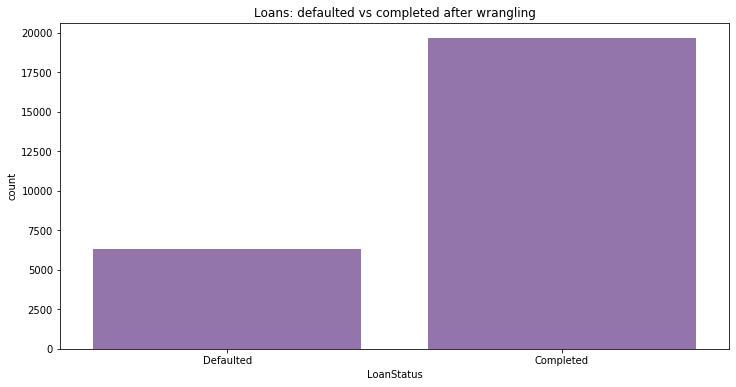

In [9]:
plt.figure(figsize=[12, 6])
plt.title('Loans: defaulted vs completed after wrangling')
sb.countplot(data = target_df, x = 'LoanStatus', color = default_color);

In [10]:
# Removing outliers from income column
target_df = target_df[target_df['StatedMonthlyIncome'] < boundary]

After wrangling Distribution of Monthly income looks approximately normal with high right skew and a mean of 5328 USD and maximum value of 30416.67 USD.

In [11]:
target_df['StatedMonthlyIncome'].describe()

count   25938.00
mean     5328.39
std      3390.76
min         0.00
25%      3166.67
50%      4583.33
75%      6666.67
max     30416.67
Name: StatedMonthlyIncome, dtype: float64

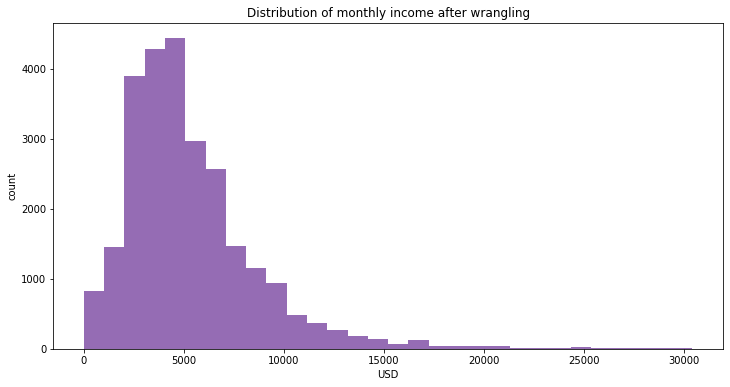

In [12]:
plt.figure(figsize=[12, 6])
plt.title('Distribution of monthly income after wrangling')
plt.ylabel('count')
plt.xlabel('USD')
plt.hist(data=target_df, x='StatedMonthlyIncome', bins=30, color=default_color);

ProsperRating is an ordinal categorical variable with the following values from higher to lower ('AA', 'A', 'B', 'C', 'D', 'E', 'HR'), ratings have almost normal distribution in data set centered at 'C' the highest 'AA' and the lowest 'HR' ratings have the least occurrences. 

In [13]:
ordinal_list = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR']
ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_list)
df['ProsperRating (Alpha)'] = df['ProsperRating (Alpha)'].astype(ordered_var)

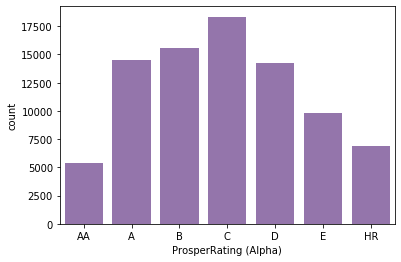

In [14]:
sb.countplot(data=df, x='ProsperRating (Alpha)', color=default_color);

In [15]:
# wrangling categorical variables
ordinal_list = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR']
ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_list)
target_df['ProsperRating (Alpha)'] = target_df['ProsperRating (Alpha)'].astype(ordered_var)

categories = {1: 'Debt Consolidation', 2: 'Home Improvement', 3: 'Business', 6: 'Auto', 7: 'Other'}
def reduce_categories(row):
    loan_category = row['ListingCategory (numeric)']
    if  loan_category in categories:
        return categories[loan_category]
    else:
        return categories[7]

target_df['ListingCategory (numeric)'] = target_df.apply(reduce_categories, axis=1)

The general trend is that the lower the Prosper rating the more there is defaults on credits, with exception of rating <b>D</b> which turns out the most common rating among defaulted credits. 

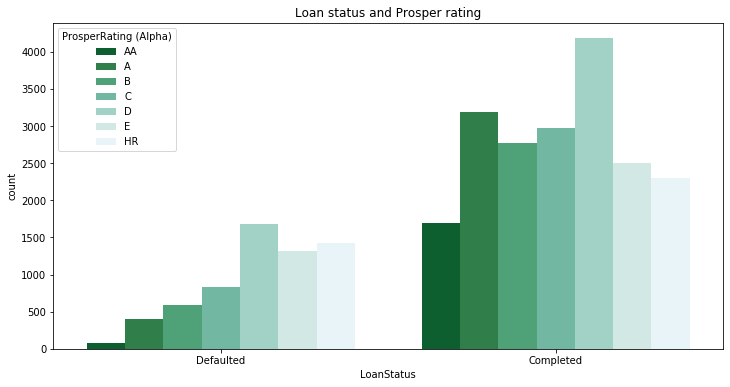

In [16]:
plt.figure(figsize=[12, 6])
plt.title('Loan status and Prosper rating')
sb.countplot(data=target_df, x='LoanStatus', hue='ProsperRating (Alpha)', palette='BuGn_r');

Individuals with employment status 'Not employed' or 'Self-employed' are more likely to default on credit:

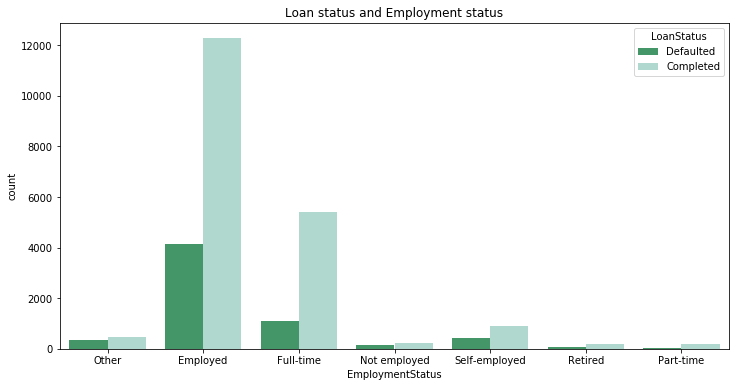

In [17]:
plt.figure(figsize = [12, 6])
plt.title('Loan status and Employment status')
sb.countplot(data=target_df, x='EmploymentStatus', hue='LoanStatus', palette='BuGn_r');

Long-term (60 months) have the greatest proportion of defaulted credits.

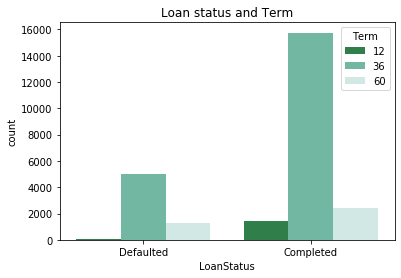

In [18]:
plt.title('Loan status and Term')
sb.countplot(data=target_df, x='LoanStatus', hue='Term', palette='BuGn_r');

Borrowers with high Prosper rating tend to borrow more, defaulted loans tend to be larger than completed for high rating borrowers. Borrowers with low rating on the other hand tend to borrow less and their defaulted credits usually as big as completed.

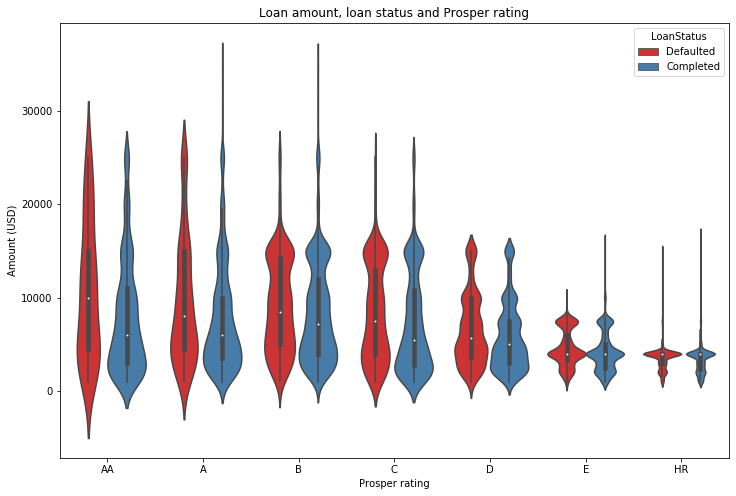

In [19]:
plt.figure(figsize = [12, 8])
plt.title('Loan amount, loan status and Prosper rating')
sb.violinplot(data=target_df, x='ProsperRating (Alpha)', y='LoanOriginalAmount', hue='LoanStatus', palette="Set1")
plt.xlabel('Prosper rating')
plt.ylabel('Amount (USD)');

Business and Home Improvement categories proved to be riskier than others.

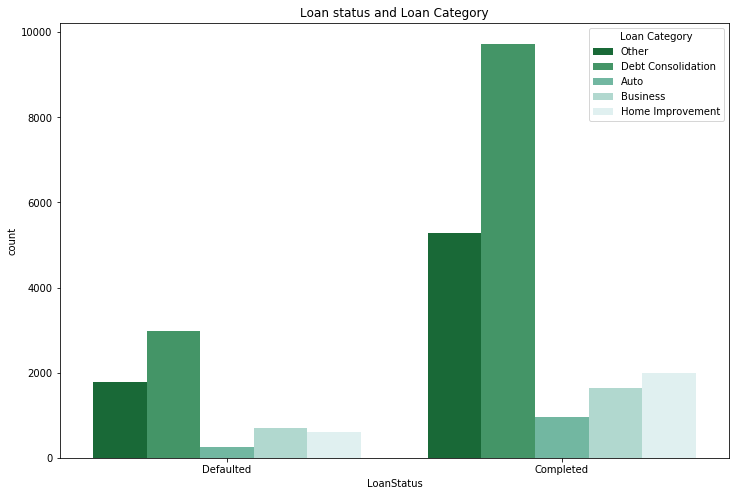

In [20]:
plt.figure(figsize = [12, 8])
plt.title('Loan status and Loan Category')
g = sb.countplot(data=target_df, x='LoanStatus', hue='ListingCategory (numeric)', palette='BuGn_r')
g.legend_.set_title('Loan Category')

Individuals with high rating tend to have higher monthly income.

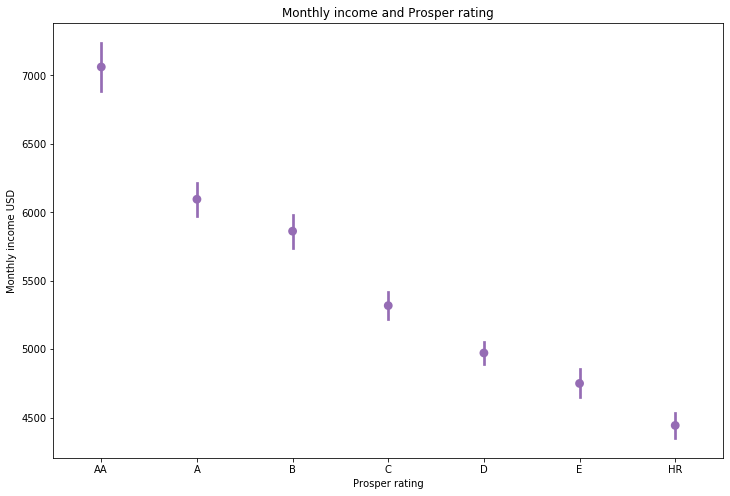

In [21]:
plt.figure(figsize = [12, 8])
plt.title('Monthly income and Prosper rating')
sb.pointplot(data = target_df, x = 'ProsperRating (Alpha)', y = 'StatedMonthlyIncome', linestyles = '', color = default_color)
plt.xlabel('Prosper rating')
plt.ylabel('Monthly income USD');

As Prosper rating lowers the proportion of individuals with employment statuses 'Not employed', 'Self-employed' and 'Retired' increases.

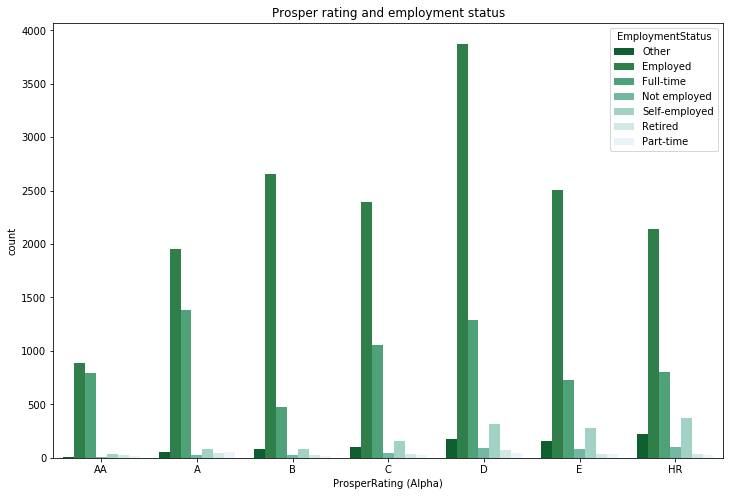

In [22]:
plt.figure(figsize = [12, 8])
plt.title('Prosper rating and employment status')
sb.countplot(data = target_df, x = 'ProsperRating (Alpha)', hue = 'EmploymentStatus', palette='BuGn_r');